# Import Github Repo

In [3]:
# Import Github repo
from google.colab import files
import zipfile
import os

print('Upload project file')
uploaded = files.upload()

zip = list(uploaded.keys())[0]
with zipfile.ZipFile(zip, 'r') as zip_ref:
  zip_ref.extractall('/content')

print(f'Extracted {zip}')
print('Availale Files/Folders')
for item in os.listdir('/content'):
  print(f'{item}')

Upload project file


Saving NNIK.zip to NNIK.zip
Extracted NNIK.zip
Availale Files/Folders
.config
NNIK.zip
NNIK
sample_data


# Setup directory, system paths, and install dependencies


*   Configure project directories and update system paths. Ensure project modules load correctly
*   Install Python dependencies such as PyTorch, NumPy, and Matplotlib
*   Import custom project modules





In [4]:
import sys
from pathlib import Path

root = Path('/content/NNIK') if Path('/content/NNIK').exists() else Path('/content/NNIK-main')
print(f'Project root - {root}')
print(f'Project exists - {root.exists()}')

remove = [p for p in sys.path if 'NNIK' in p or 'Scripts' in p]
for path in remove:
  sys.path.remove(path)

project_paths = [
    str(root),
    str(root / 'Scripts'),
    str(root / 'Scripts' / 'Models'),
    str(root / 'Scripts' / 'Models' / 'Machine_Learning'),
    str(root / 'Scripts' / 'Models' / 'Traditional'),
]

for path in project_paths:
  if path not in sys.path:
    sys.path.insert(0, path)

print('Paths configured')

Project root - /content/NNIK
Project exists - True
Paths configured


In [5]:
!pip install -q torch torchvision torchaudio scikit-learn pandas matplotlib numpy tqdm pyyaml scipy

In [6]:
# Import project modules
import importlib.util
import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import yaml
from datetime import datetime

def import_path(module_name, file_path):
  try:
    if not file_path.exists():
      print(f'File not found - {file_path}')
      return None

    spec = importlib.util.spec_from_file_location(module_name, file_path)
    if spec is None or spec.loader is None:
      print(f'Couldnt create spec for {module_name}')
      return None

    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module
  except Exception as e:
    print(f'Error importing {module_name} - {str(e)}')
    return None

utils_module = import_path('utils', root / 'Scripts' / 'utils.py')
data_gen_module = import_path('data_gen', root / 'Scripts' / 'data_gen.py')
training_module = import_path('training', root / 'Scripts' / 'training.py')
testing_module = import_path('testing', root / 'Scripts' / 'testing.py')

if utils_module:
    print('utils.py imported')
if data_gen_module:
    print('data_gen.py imported')
if training_module:
    print('training.py imported')
if testing_module:
    print('testing.py imported')

utils.py imported
data_gen.py imported
training.py imported
testing.py imported


# Quick Test (Just to check if its working)

In [7]:
# Quick test
data_directory = root / 'data'
print(f'data directory - {data_directory}')
print(f'data directory exists - {data_directory.exists()}')

if data_directory.exists():
  print('\nTraining data - ')
  training_directory = data_directory / 'Training'
  if training_directory.exists():
    training_files = list(training_directory.glob('*.json'))
    print(f'Found {len(training_files)} training files')
    for f in sorted(training_files)[:5]:
      print(f.name)
  print('\nTesting data:')
  testing_directory = data_directory / 'Testing'
  if testing_directory.exists():
    testing_files = list(testing_directory.glob('*.json'))
    print(f'Found {len(testing_files)} testing files')
    for f in sorted(testing_files)[:5]:
      print(f.name)



data directory - /content/NNIK/data
data directory exists - True

Training data - 
Found 16 training files
10_training.json
10_training_solutions.json
3_training.json
3_training_solutions.json
4_training.json

Testing data:
Found 16 testing files
10_testing.json
10_testing_solutions.json
3_testing.json
3_testing_solutions.json
4_testing.json


# Training
This section prepares the training data, builds candidate models, trains them, and summarizes results.

First, the code loads inverse kinematics data for each degree of freedom (DOF). It reads JSON files containing poses and solutions, then prepares input arrays (X_train) and output arrays (y_train). If the dataset is too large, it can randomly sample a smaller subset to reduce computation.

Next, multiple model types are created for each DOF. These include:

*  ANN (Artificial Neural Network)

*  KNN (K-Nearest Neighbors)

*  ELM (Extreme Learning Machine)

*  RandomForest

*  SVM (Support Vector Machine)

*  MDN (Mixture Density Network)

*  CVAE (Conditional Variational Autoencoder)


Training is then performed using train_all_models. Each model is trained on the dataset, and the script records:

*  Training time

*  Number of samples used

*  Whether training succeeded or failed

All trained models are saved under their respective DOFs. A results list tracks performance for each model.

Finally, the training results are summarized in a DataFrame. The summary includes total models trained, average training times, and statistics grouped by model and DOF. Successful and failed models are clearly marked for later analysis.

In [8]:
# Training
from Scripts.training import load_ik_data, train_all_models, setup_gpu
from Scripts.testing import create_ml_models
import numpy as np
import pandas as pd
import torch

dof_range = [3, 4, 5, 6, 7, 8, 9, 10]
sample_limit = None

device = setup_gpu()


all_trained_models = {}
all_training_results = []

for dof in dof_range:
    print(f'\nDOF={dof} training')

    train_poses = data_directory / 'Training' / f'{dof}_training.json'
    train_solutions = data_directory / 'Training' / f'{dof}_training_solutions.json'

    if not (train_poses.exists() and train_solutions.exists()):
        print(f'no data for DOF={dof}')
        continue

    X_train, y_train = load_ik_data(train_poses, train_solutions)

    if sample_limit and len(X_train) > sample_limit:
        idx = np.random.choice(len(X_train), sample_limit, replace=False)
        X_train, y_train = X_train[idx], y_train[idx]

    print(f'Training data - {X_train.shape} -> {y_train.shape}')

    models_for_dof = create_ml_models(input_dim=X_train.shape[1], output_dim=y_train.shape[1])

    selected_models = {}
    for name in ['ANN', 'KNN', 'ELM', 'RandomForest', 'SVM', 'MDN', 'CVAE']:
        if name in models_for_dof and models_for_dof[name] is not None:
            selected_models[name] = models_for_dof[name]

    print(f'models: {list(selected_models.keys())}')

    trained_models = train_all_models(selected_models, X_train, y_train, use_parallel=True)

    all_trained_models[dof] = trained_models

    for name, result in trained_models.items():
        if 'error' not in result:
            all_training_results.append({
                'dof': dof,
                'model': name,
                'training_time': result['training_time'],
                'samples': len(X_train),
                'status': 'success'
            })
        else:
            all_training_results.append({
                'dof': dof,
                'model': name,
                'training_time': 0,
                'samples': len(X_train),
                'status': f'failed: {result['error'][:50]}'
            })

    print(f'\nDOF={dof} training complete - {len([r for r in trained_models.values() if 'error' not in r])} models trained')

print(f'\nTraining Complete')

training_df = pd.DataFrame(all_training_results)
if not training_df.empty:
    print('Training Summary:')
    print(training_df)

    successful = training_df[training_df['status'] == 'success']
    if not successful.empty:
        print(f'\nStatistics:')
        pivot = successful.pivot_table(values='training_time', index='model', columns='dof', aggfunc='mean')
        print(pivot.round(2))

print(f'\nTotal trained models: {sum(len([m for m in models.values() if 'error' not in m]) for models in all_trained_models.values())}')

GPU: Tesla T4 (15.8 GB)

DOF=3 training
Loaded data: X shape = (2000, 6), y shape = (2000, 3)
DOF from data: 3
Training data - (2000, 6) -> (2000, 3)
models: ['ANN', 'KNN', 'ELM', 'RandomForest', 'SVM', 'MDN', 'CVAE']
GPU: Tesla T4 (15.8 GB)

Training 4 CPU models in parallel...
Training KNN...
Training ELM...
  ✓ KNN completed in 0.01s
Training RandomForest...
Training SVM...
  ✓ ELM completed in 0.28s
  ✓ RandomForest completed in 0.51s
  ✓ SVM completed in 0.79s

Training 3 GPU models...
Training ANN...
  Using GPU for ANN
Epoch [20/20], Train Loss: 0.5732, Val Loss: 0.4892
  ✓ ANN completed in 11.15s
Training MDN...
  Using GPU for MDN
Epoch [20/50], Loss: -0.3281
Epoch [40/50], Loss: -1.5316
  ✓ MDN completed in 10.24s
Training CVAE...
  Using GPU for CVAE
Epoch [20/50], Loss: 0.8865
Epoch [40/50], Loss: 0.6276
  ✓ CVAE completed in 9.45s

GPU Memory: 0.02 GB allocated

DOF=3 training complete - 7 models trained

DOF=4 training
Loaded data: X shape = (2000, 6), y shape = (2000, 4)

# Testing
This section evaluates the trained models and traditonal solvers on unseen data and generates detailed performance metrics.

The script first loads testing datasets for each DOF. These are JSON files containing test poses and solutions. As with training, the inputs (X_test) and outputs (y_test) are prepared, with optional downsampling for large datasets.

Each trained model is then evaluated using evaluate_all_models. Performance metrics are collected, including:

* Position RMSE (Cartesian error)

* Joint RMSE (error in joint space)

* Training time

* Inference time per sample

* Number of test samples used

Results are stored in a list that records metrics across all models and DOFs.

Once evaluation is complete, results are compiled into a DataFrame and saved to a CSV file in the results directory. The script then prints performance tables and creates a summary that aggregates metrics across models. This makes it easier to compare accuracy, speed, and efficiency between approaches.

In [9]:
from Scripts.testing import evaluate_all_models, results_dataframe, Traditional, create_traditional_models

all_test_results = []

print('\n')
print('Testing')

for dof, trained_models in all_trained_models.items():
    if not trained_models:
        continue

    print(f'\nDOF={dof}')

    # Load test data
    test_poses = data_directory / 'Testing' / f'{dof}_testing.json'
    test_solutions = data_directory / 'Testing' / f'{dof}_testing_solutions.json'

    if not (test_poses.exists() and test_solutions.exists()):
        print(f'Testing data not found for dof={dof}')
        continue

    X_test, y_test = load_ik_data(test_poses, test_solutions)

    if sample_limit and len(X_test) > sample_limit//3:
        idx = np.random.choice(len(X_test), sample_limit//3, replace=False)
        X_test, y_test = X_test[idx], y_test[idx]

    print(f'Test data: {X_test.shape} -> {y_test.shape}')

    traditional_models = create_traditional_models(
        output_dim=y_test.shape[1],
        timeout_analytical=0.2,
        timeout_jacobian=0.5,
        timeout_sdls=0.8
    )

    for model in traditional_models.values():
        model.fit(X_test[:1], y_test[:1])

    all_models_for_test = {}

    all_models_for_test.update(trained_models)

    for name, model in traditional_models.items():
        all_models_for_test[name] = {
            'model': model,
            'training_time': 0.0
        }

    print(f'Testing {len(all_models_for_test)} models: {list(all_models_for_test.keys())}')

    evaluation_results = evaluate_all_models(all_models_for_test, X_test, y_test, force_cpu=False)

    model_type_mapping = {name: 'Traditional' if name.endswith('_IK') else 'ML'
                         for name in all_models_for_test.keys()}

    df = results_dataframe(evaluation_results, dof=dof, model_type_mapping=model_type_mapping)

    if not df.empty:
        all_test_results.append(df)

    print(f'DOF={dof} testing complete - {len(evaluation_results)} models evaluated')

print(f'\nEnhanced testing complete!')

if all_test_results:
    results_df = pd.concat(all_test_results, ignore_index=True)

    results_path = root / 'results'
    results_path.mkdir(exist_ok=True)
    results_df.to_csv(results_path / 'enhanced_ml_traditional_results.csv', index=False)

    print(f'Total experiments: {len(results_df)}')
    print('Enhanced Results Summary:')
    print(f"ML Models: {len(results_df[results_df['model_type'] == 'ML'])}")
    print(f"Traditional Models: {len(results_df[results_df['model_type'] == 'Traditional'])}")

    if len(results_df[results_df['model_type'] == 'ML']) > 0 and len(results_df[results_df['model_type'] == 'Traditional']) > 0:
        ml_avg = results_df[results_df['model_type'] == 'ML']['inference_time_per_sample'].mean() * 1000
        trad_avg = results_df[results_df['model_type'] == 'Traditional']['inference_time_per_sample'].mean() * 1000

        print(f"\nInference Speed Comparison:")
        print(f"ML Models Average: {ml_avg:.2f} ms per sample")
        print(f"Traditional Methods Average: {trad_avg:.2f} ms per sample")
        print(f"Traditional methods are {trad_avg/ml_avg:.1f}x slower on average")

else:
    print('No enhanced test results available')
    results_df = None



Testing

DOF=3
Loaded data: X shape = (1000, 6), y shape = (1000, 3)
DOF from data: 3
Test data: (1000, 6) -> (1000, 3)
Testing 10 models: ['KNN', 'ELM', 'RandomForest', 'SVM', 'ANN', 'MDN', 'CVAE', 'Analytical_IK', 'Jacobian_IK', 'SDLS_IK']
Evaluating KNN...
  ✓ Joint RMSE: 1.0648, Inference: 0.007s
Evaluating ELM...
  ✓ Joint RMSE: 1.3555, Inference: 0.000s
Evaluating RandomForest...
  ✓ Joint RMSE: 0.8570, Inference: 0.013s
Evaluating SVM...
  ✓ Joint RMSE: 1.1026, Inference: 0.124s
Evaluating ANN...
  ✓ Joint RMSE: 1.3117, Inference: 0.002s
Evaluating MDN...
  ✓ Joint RMSE: 1.3699, Inference: 0.001s
Evaluating CVAE...
  ✓ Joint RMSE: 0.9395, Inference: 0.004s
Evaluating Analytical_IK...
  Running Analytical on 1000 samples (timeout: 0.2s per sample)...
    Analytical: 100.0% success rate (0 timeouts, 0 other failures)
  ✓ Joint RMSE: 2.4316, Inference: 0.023s
Evaluating Jacobian_IK...
  Running Jacobian on 1000 samples (timeout: 0.5s per sample)...
    Jacobian: 100.0% success ra

figures

Generating publication-ready figures...
Generating Academic Research Figures
  ✓ Accuracy-Speed Tradeoff
  ✓ RMSE Heatmap
  ✓ Training Time Distribution
  ✓ Inference Speed Ranking
  ✓ Accuracy vs DOF
  ✓ ML vs Traditional Accuracy
  ✓ ML vs Traditional Speed
  ✓ Speedup Factors
  ✓ Comprehensive Dashboard

✅ Generated 9 PDF files in /content/NNIK/results/figures

All figures use:
  • Professional academic style
  • Inferno-inspired color scheme
  • 300 DPI resolution

Displaying Comprehensive Dashboard...


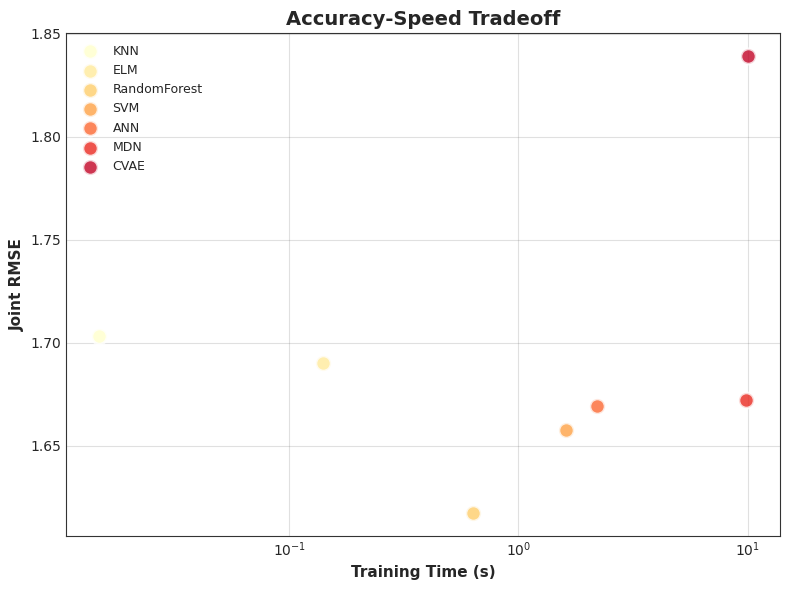

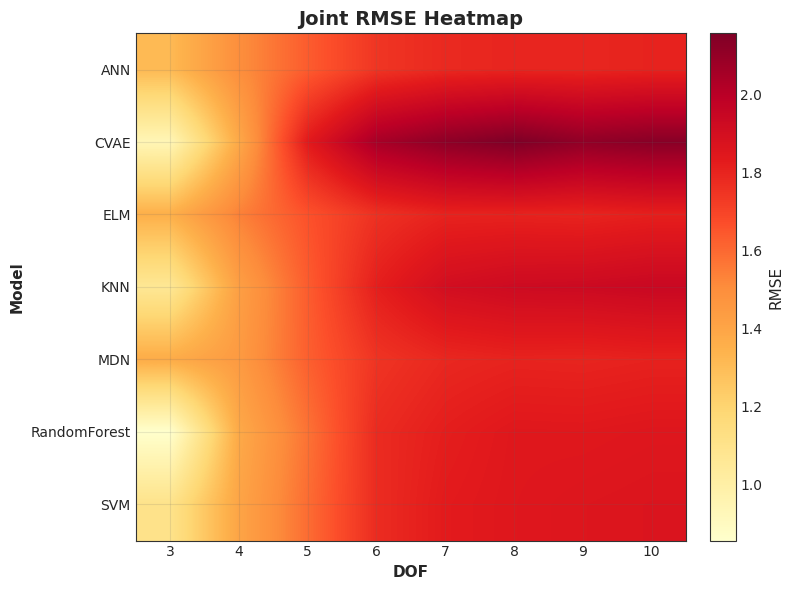

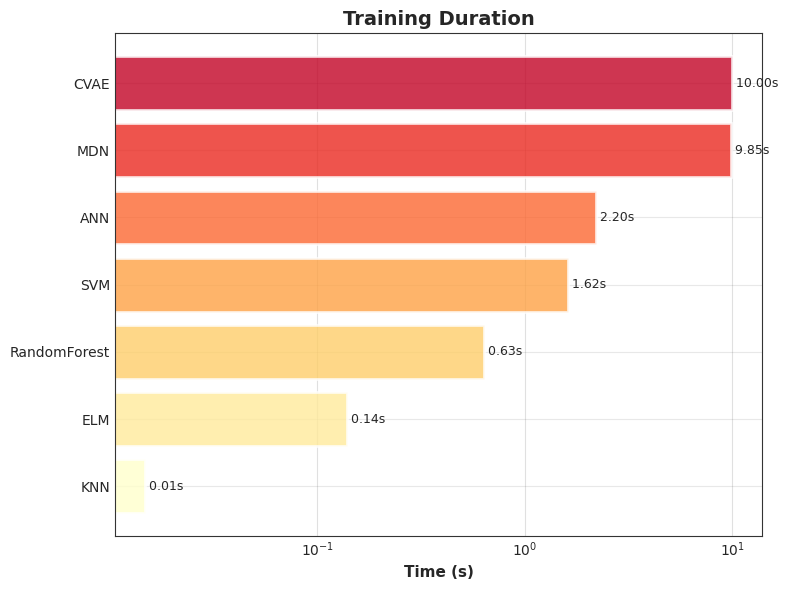

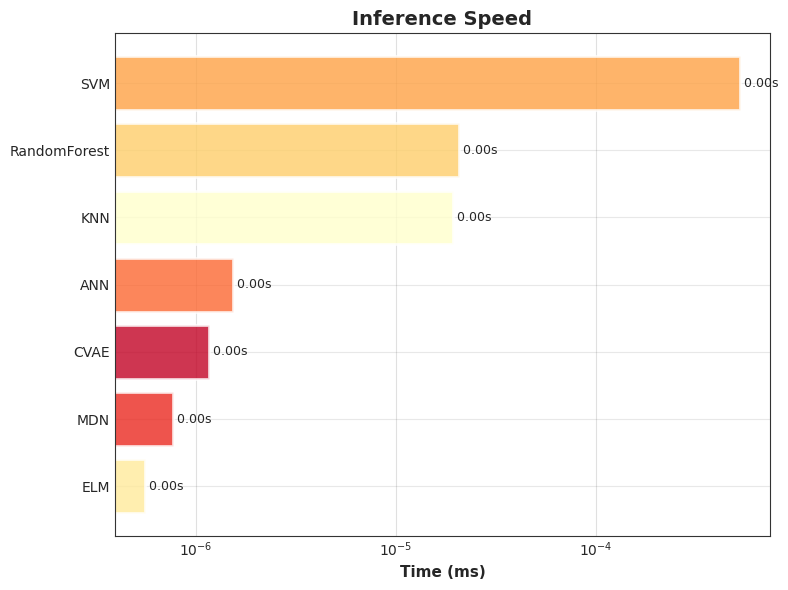

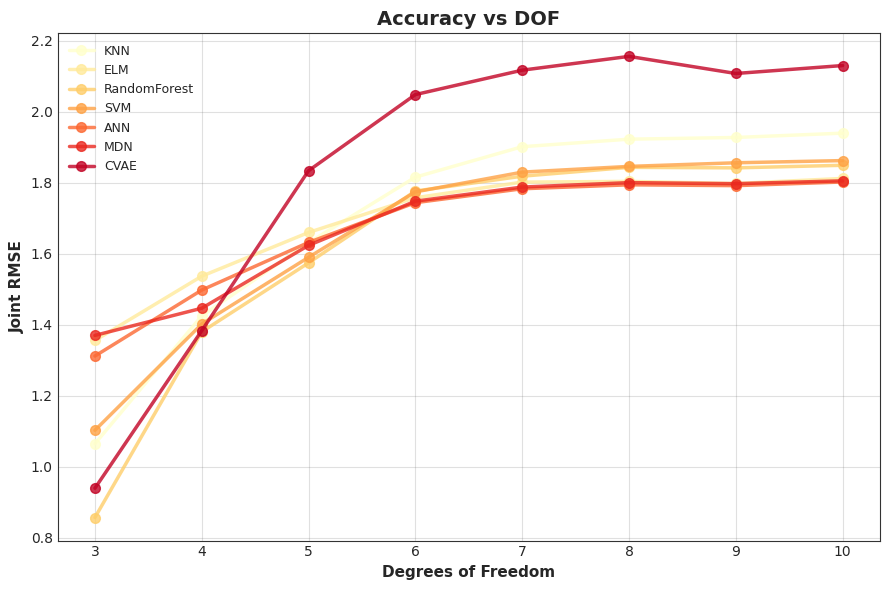

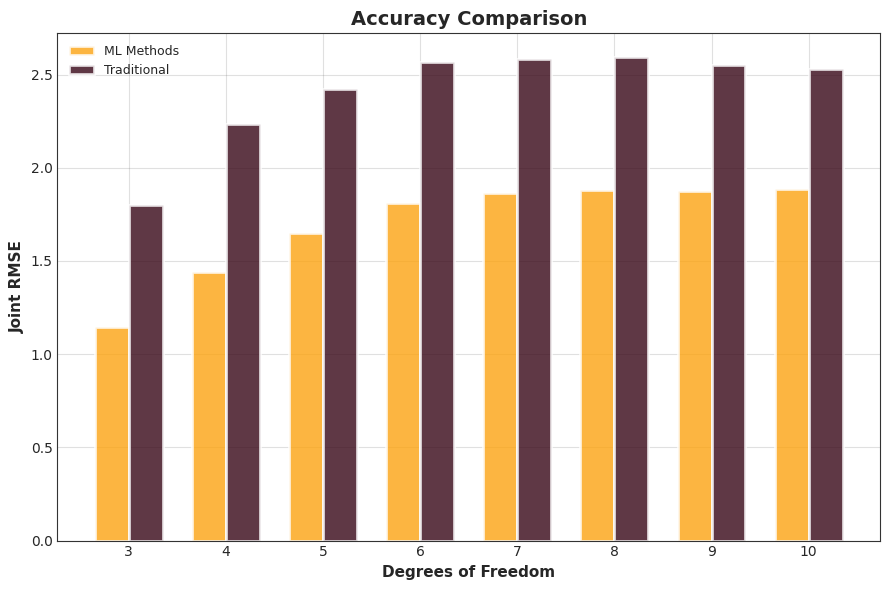

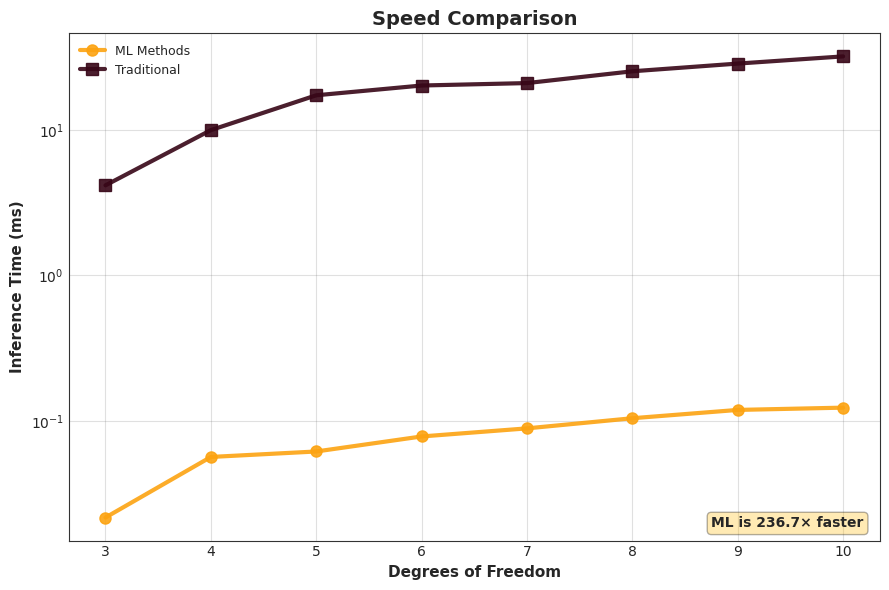

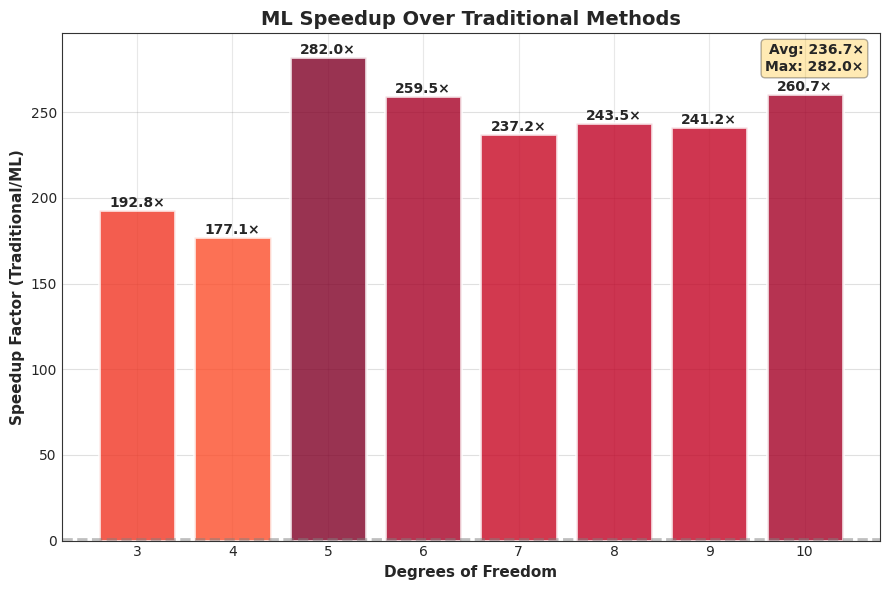

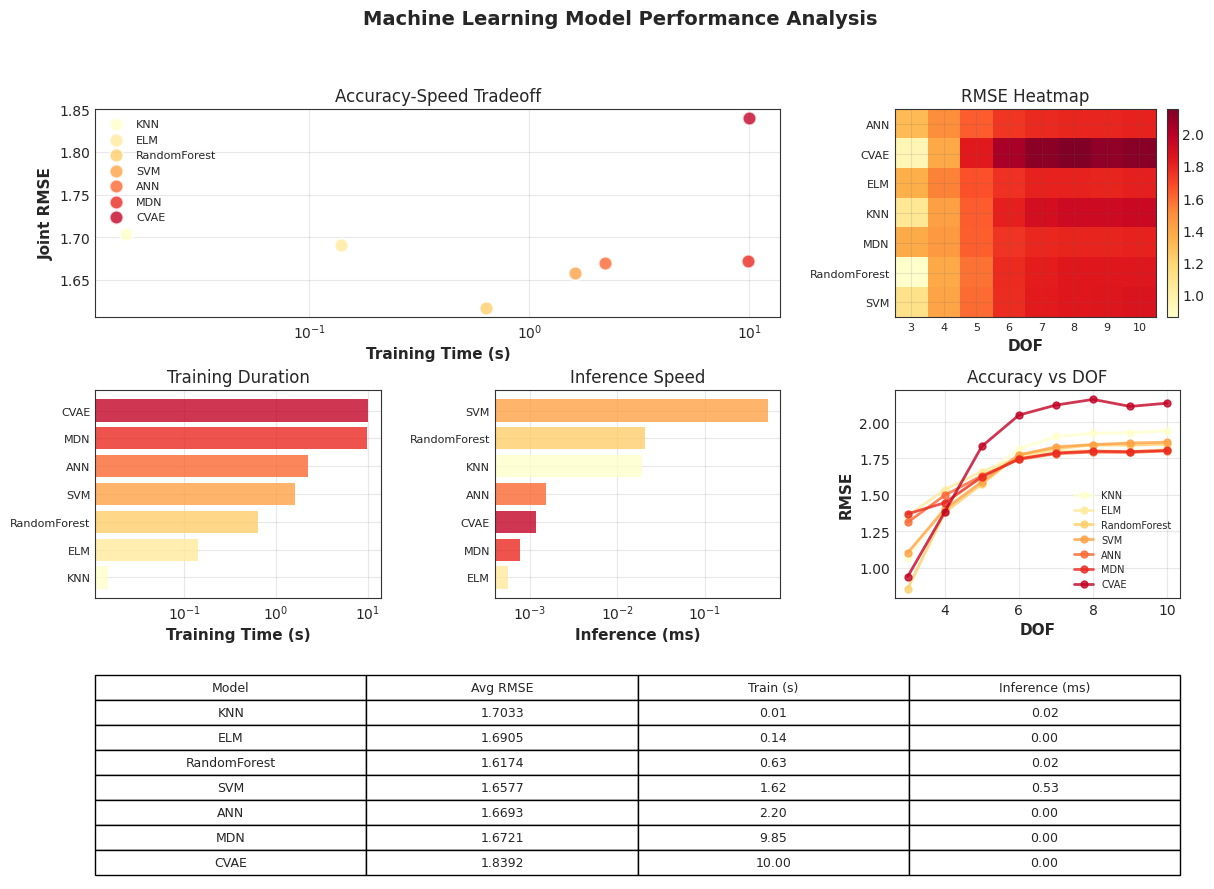

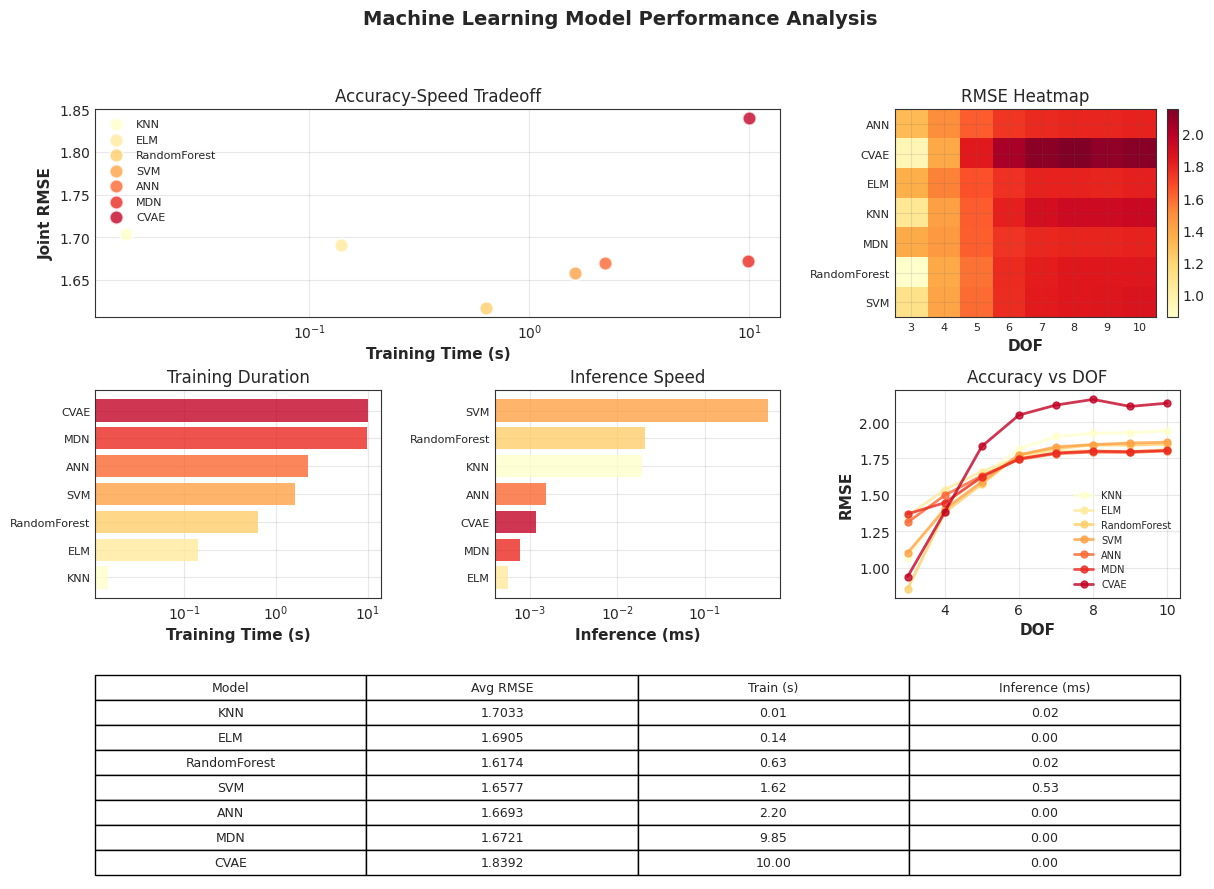


Displaying ML vs Traditional Comparisons...


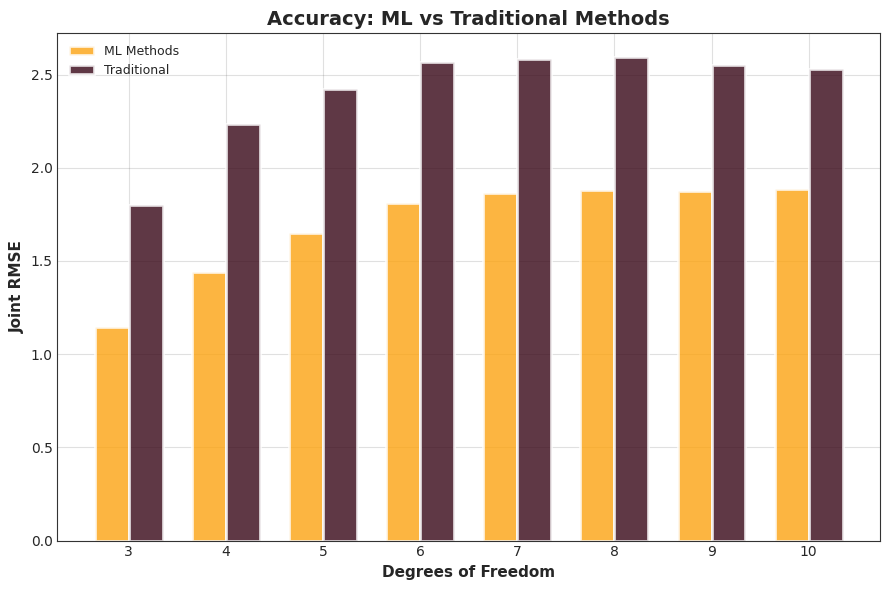

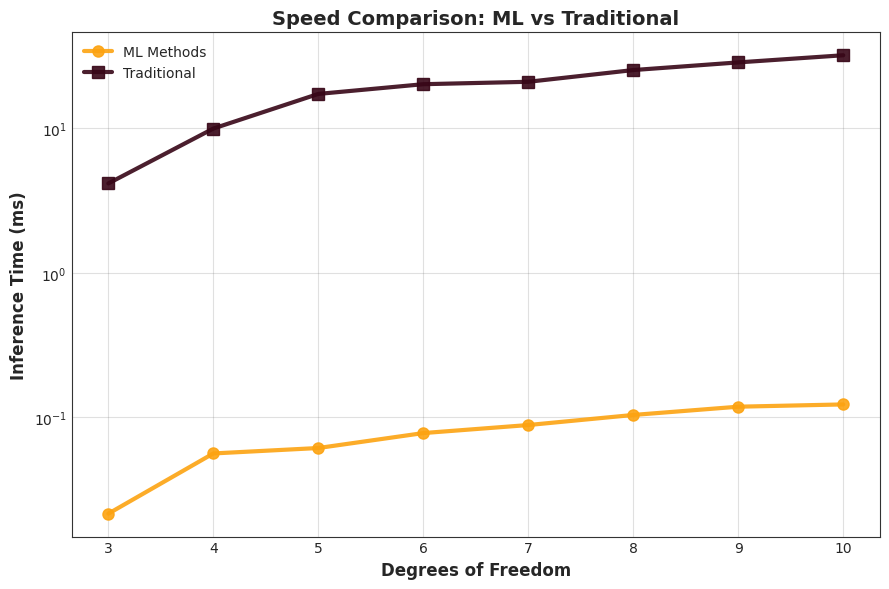

stats

Dataset Overview:
Total experiments: 80
Unique models: 10
DOF configurations: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]

Model Distribution:
ML Models: 56 experiments
Traditional Methods: 24 experiments

Inference Speed Analysis:
ML Models average: 0.08 ms/sample
Traditional IK average: 19.85 ms/sample
Speedup factor: 243.6× (ML faster)

Accuracy Analysis:
ML Models average RMSE: 1.6928
Traditional IK average RMSE: 2.4102
ML models are 29.8% more accurate

Top Performers:
Best Accuracy: Jacobian_IK
DOF: 3
RMSE: 0.2209
Fastest Inference: ELM
DOF: 3
Time: 0.00 ms/sample

Best ML Model:
Accuracy: RandomForest (RMSE=0.8570)
Speed: ELM (0.00 ms)

Best Traditional Method:
Accuracy: Jacobian_IK (RMSE=0.2209)
Speed: Analytical_IK (0.02 ms)

Training Efficiency (ML Models):
Fastest to train: KNN
Training time: 0.01 seconds
DOF: 9

Performance by DOF:

DOF=3:
Samples: 10
Avg RMSE: 1.3407
Avg Inference: 1.26 ms
ML speedup: 192

In [10]:
# Visualization and Analysis
from Scripts.plots import generate_all_figures, style
from Scripts.plots import colors, calculate_stats
from Scripts.plots import create_comprehensive_dashboard
from Scripts.plots import plot_ml_vs_traditional
import matplotlib.pyplot as plt
import os
import numpy as np

if results_df is not None and not results_df.empty:
    print('figures')
    figures_dir = results_path / 'figures'
    os.makedirs(figures_dir, exist_ok=True)
    print("\nGenerating publication-ready figures...")
    generate_all_figures(results_df, output_dir=str(figures_dir))
    style()

    # Display comprehensive dashboard
    print("\nDisplaying Comprehensive Dashboard...")
    fig = create_comprehensive_dashboard(results_df)
    plt.show()

    # Display ML vs Traditional comparison if applicable
    if 'model_type' in results_df.columns:
        print("\nDisplaying ML vs Traditional Comparisons...")

        # Accuracy comparison
        fig = plot_ml_vs_traditional(results_df, 'joint_rmse',
                                    'Accuracy: ML vs Traditional Methods',
                                    'Joint RMSE', use_bars=True)
        plt.show()

        # Speed comparison (without the annotation on the plot)
        fig, ax = plt.subplots(figsize=(9, 6))
        style()
        color_palette = colors()

        ml_df = results_df[results_df['model_type'] == 'ML']
        trad_df = results_df[results_df['model_type'] == 'Traditional']

        ml_speed = ml_df.groupby('dof')['inference_time_per_sample'].mean() * 1000
        trad_speed = trad_df.groupby('dof')['inference_time_per_sample'].mean() * 1000

        ax.plot(ml_speed.index, ml_speed.values, 'o-',
               color=color_palette['ml'], linewidth=3, markersize=8,
               label='ML Methods', alpha=0.9)
        ax.plot(trad_speed.index, trad_speed.values, 's-',
               color=color_palette['traditional'], linewidth=3, markersize=8,
               label='Traditional', alpha=0.9)

        ax.set_xlabel('Degrees of Freedom', fontweight='bold', fontsize=12)
        ax.set_ylabel('Inference Time (ms)', fontweight='bold', fontsize=12)
        ax.set_title('Speed Comparison: ML vs Traditional', fontsize=14, fontweight='bold')
        ax.set_yscale('log')
        ax.legend(loc='upper left', framealpha=0.9, fontsize=10)
        ax.grid(True, alpha=0.2)

        plt.tight_layout()
        plt.show()

    print('stats')

    print(f'\nDataset Overview:')
    print(f'Total experiments: {len(results_df)}')
    print(f'Unique models: {results_df["model"].nunique()}')
    print(f'DOF configurations: {sorted(results_df["dof"].unique())}')

    # Model type breakdown
    if 'model_type' in results_df.columns:
        ml_df = results_df[results_df['model_type'] == 'ML']
        trad_df = results_df[results_df['model_type'] == 'Traditional']

        ml_count = len(ml_df)
        trad_count = len(trad_df)

        print(f'\nModel Distribution:')
        print(f'ML Models: {ml_count} experiments')
        print(f'Traditional Methods: {trad_count} experiments')

        # Speed comparison statistics
        if ml_count > 0 and trad_count > 0:
            ml_avg_speed = ml_df['inference_time_per_sample'].mean() * 1000
            trad_avg_speed = trad_df['inference_time_per_sample'].mean() * 1000
            speedup_factor = trad_avg_speed / ml_avg_speed

            print(f'\nInference Speed Analysis:')
            print(f'ML Models average: {ml_avg_speed:.2f} ms/sample')
            print(f'Traditional IK average: {trad_avg_speed:.2f} ms/sample')
            print(f'Speedup factor: {speedup_factor:.1f}× (ML faster)')

            # Accuracy comparison
            ml_avg_rmse = ml_df['joint_rmse'].mean()
            trad_avg_rmse = trad_df['joint_rmse'].mean()
            accuracy_diff = ((trad_avg_rmse - ml_avg_rmse) / trad_avg_rmse) * 100

            print(f'\nAccuracy Analysis:')
            print(f'ML Models average RMSE: {ml_avg_rmse:.4f}')
            print(f'Traditional IK average RMSE: {trad_avg_rmse:.4f}')
            if ml_avg_rmse < trad_avg_rmse:
                print(f'ML models are {abs(accuracy_diff):.1f}% more accurate')
            else:
                print(f'Traditional methods are {abs(accuracy_diff):.1f}% more accurate')

            # Timeout analysis for traditional methods
            if 'timeout_count' in results_df.columns:
                total_timeouts = trad_df['timeout_count'].sum()
                timeout_rate = (total_timeouts / trad_count * 100) if trad_count > 0 else 0

                if total_timeouts > 0:
                    print(f'\nTraditional Methods Timeout Analysis:')
                    print(f'Total timeouts/failures: {total_timeouts}')
                    print(f'Timeout rate: {timeout_rate:.1f}% of attempts')

    # Overall best performers
    print(f'\nTop Performers:')

    best_accuracy = results_df.loc[results_df['joint_rmse'].idxmin()]
    print(f'Best Accuracy: {best_accuracy["model"]}')
    print(f'DOF: {best_accuracy.get("dof", "N/A")}')
    print(f'RMSE: {best_accuracy["joint_rmse"]:.4f}')

    fastest_inference = results_df.loc[results_df['inference_time_per_sample'].idxmin()]
    print(f'Fastest Inference: {fastest_inference["model"]}')
    print(f'DOF: {fastest_inference.get("dof", "N/A")}')
    print(f'Time: {fastest_inference["inference_time_per_sample"]*1000:.2f} ms/sample')

    # Best per category
    if 'model_type' in results_df.columns:
        if not ml_df.empty:
            best_ml = ml_df.loc[ml_df['joint_rmse'].idxmin()]
            fastest_ml = ml_df.loc[ml_df['inference_time_per_sample'].idxmin()]
            print(f'\nBest ML Model:')
            print(f'Accuracy: {best_ml["model"]} (RMSE={best_ml["joint_rmse"]:.4f})')
            print(f'Speed: {fastest_ml["model"]} ({fastest_ml["inference_time_per_sample"]*1000:.2f} ms)')

        if not trad_df.empty:
            best_trad = trad_df.loc[trad_df['joint_rmse'].idxmin()]
            fastest_trad = trad_df.loc[trad_df['inference_time_per_sample'].idxmin()]
            print(f'\nBest Traditional Method:')
            print(f'Accuracy: {best_trad["model"]} (RMSE={best_trad["joint_rmse"]:.4f})')
            print(f'Speed: {fastest_trad["model"]} ({fastest_trad["inference_time_per_sample"]*1000:.2f} ms)')

    # Training efficiency (ML only)
    if 'model_type' in results_df.columns and not ml_df.empty:
        fastest_training = ml_df.loc[ml_df['training_time'].idxmin()]
        print(f'\nTraining Efficiency (ML Models):')
        print(f'Fastest to train: {fastest_training["model"]}')
        print(f'Training time: {fastest_training["training_time"]:.2f} seconds')
        print(f'DOF: {fastest_training.get("dof", "N/A")}')

    # Summary by DOF
    print(f'\nPerformance by DOF:')
    for dof in sorted(results_df['dof'].unique()):
        dof_data = results_df[results_df['dof'] == dof]
        print(f'\nDOF={dof}:')
        print(f'Samples: {len(dof_data)}')
        print(f'Avg RMSE: {dof_data["joint_rmse"].mean():.4f}')
        print(f'Avg Inference: {dof_data["inference_time_per_sample"].mean()*1000:.2f} ms')

        if 'model_type' in results_df.columns:
            ml_dof = dof_data[dof_data['model_type'] == 'ML']
            trad_dof = dof_data[dof_data['model_type'] == 'Traditional']
            if not ml_dof.empty and not trad_dof.empty:
                speedup = trad_dof['inference_time_per_sample'].mean() / ml_dof['inference_time_per_sample'].mean()
                print(f'ML speedup: {speedup:.1f}×')

    print(f'\n')
    print(f'results saved to: {results_path}')
    print(f'figures saved to: {figures_dir}')

else:
    print('No results data available for analysis')